Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Combined Tweets Classifier Accuracy: 0.8126112382405288
Combined Tweets Classifier Report:
               precision    recall  f1-score   support

           0       0.86      0.68      0.76      3368
           1       0.79      0.91      0.85      4498

    accuracy                           0.81      7866
   macro avg       0.82      0.80      0.80      7866
weighted avg       0.82      0.81      0.81      7866



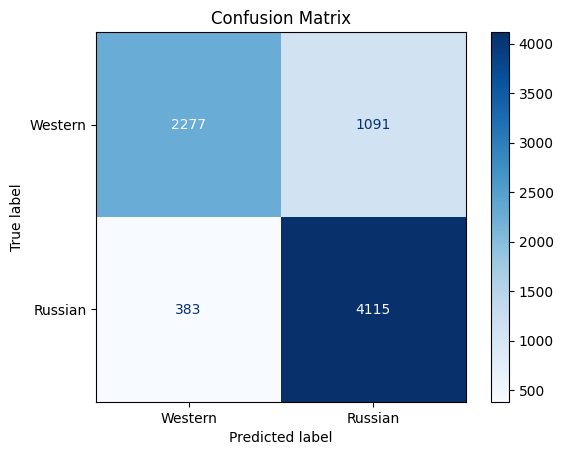

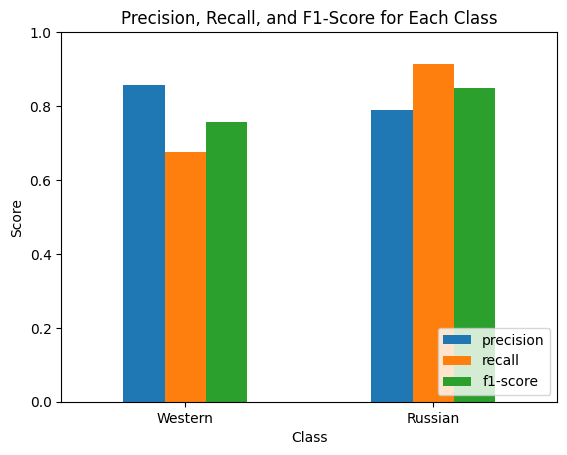

In [2]:
# Install the necessary packages if they are not already installed
%pip install nltk matplotlib seaborn

import re
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Ensure necessary NLTK data is downloaded
nltk.download('stopwords')
from nltk.corpus import stopwords

# Load the combined CSV file
df_combined = pd.read_csv('merged_df.csv')

# Assume tweets are in a column named 'tweet' and labels are in a column named 'label'
tweets_combined = df_combined['tweet'].tolist()
labels_combined = df_combined['Russian'].tolist()

# Function to preprocess the tweets
def preprocess_tweet(tweet):
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    tweet = re.sub(r'\@\w+|\#','', tweet)
    tweet = tweet.lower()
    tweet = re.sub(r'[^\w\s]', '', tweet)
    return tweet

# Preprocess all tweets
tweets_combined = [preprocess_tweet(tweet) for tweet in tweets_combined]

# Split the combined data into training and testing sets
X_train_comb, X_test_comb, y_train_comb, y_test_comb = train_test_split(tweets_combined, labels_combined, test_size=0.2, random_state=42)

# Initialize the TF-IDF vectorizer for combined data
vectorizer_comb = TfidfVectorizer(stop_words=stopwords.words('english') + stopwords.words('russian'))

# Fit and transform the training data, transform the testing data
X_train_comb_tfidf = vectorizer_comb.fit_transform(X_train_comb)
X_test_comb_tfidf = vectorizer_comb.transform(X_test_comb)

# Initialize the Logistic Regression model for combined data
model_comb = LogisticRegression()

# Train the model
model_comb.fit(X_train_comb_tfidf, y_train_comb)

# Predict the labels for the test set
y_pred_comb = model_comb.predict(X_test_comb_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test_comb, y_pred_comb)
report = classification_report(y_test_comb, y_pred_comb, output_dict=True)
print("Combined Tweets Classifier Accuracy:", accuracy)
print("Combined Tweets Classifier Report:\n", classification_report(y_test_comb, y_pred_comb))

# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test_comb, y_pred_comb)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Western', 'Russian'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Extract metrics for each class
metrics_df = pd.DataFrame(report).transpose()

# Plot the precision, recall, and F1-score for each class
metrics_df[['precision', 'recall', 'f1-score']].iloc[:-3].plot(kind='bar')
plt.title('Precision, Recall, and F1-Score for Each Class')
plt.xlabel('Class')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(ticks=[0, 1], labels=['Western', 'Russian'], rotation=0)
plt.legend(loc='lower right')
plt.show()
